In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2024-04-04 03:27:15--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-04-04 03:27:16--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-04-04 03:27:16--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

URL transformed to HTTPS due to an HSTS policy
--2024-04-04 03:27:53--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz [following]
--2024-04-04 03:27:53--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz [following]
--2024-04-04 03:27:54--  https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awa

In [4]:
!tar -xf images.tar.gz

In [5]:
!tar -xf annotations.tar.gz

In [6]:
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

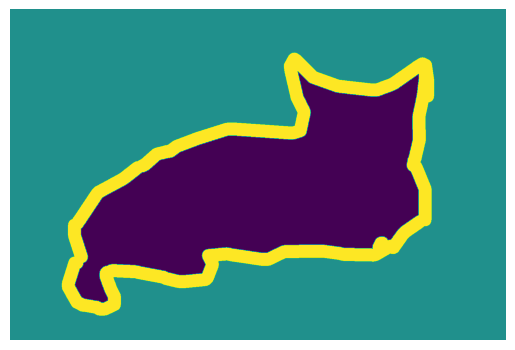

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[8]))

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[8], color_mode="grayscale"))
display_target(img)

In [8]:
import numpy as np
import random
img_size = (200, 200)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(32, 2, (2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 2, (2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 2, (2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(128, 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(128, 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D((2,2))(x)
    model = keras.Model(
        inputs=inputs,
        outputs=x
    )
    return model


In [10]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      416       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4128      
                                                             

In [11]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
epochs=10,
callbacks=callbacks,
batch_size=64,
validation_data=(val_input_imgs, val_targets))

Epoch 1/10
100/100 [==============================] - 52s 399ms/step - loss: 4.5430 - val_loss: 1.0506
Epoch 2/10
100/100 [==============================] - 36s 362ms/step - loss: 2.4378 - val_loss: 1.1159
Epoch 3/10
100/100 [==============================] - 36s 362ms/step - loss: 2.1843 - val_loss: 0.9718
Epoch 4/10
100/100 [==============================] - 36s 362ms/step - loss: 1.6546 - val_loss: 0.9159
Epoch 5/10
100/100 [==============================] - 36s 361ms/step - loss: 1.3683 - val_loss: 1.0008
Epoch 6/10
100/100 [==============================] - 36s 362ms/step - loss: 1.1713 - val_loss: 1.3943
Epoch 7/10
100/100 [==============================] - 36s 362ms/step - loss: 1.1501 - val_loss: 1.2162
Epoch 8/10
100/100 [==============================] - 36s 363ms/step - loss: 1.0865 - val_loss: 0.8790
Epoch 9/10
100/100 [==============================] - 39s 388ms/step - loss: 0.8977 - val_loss: 0.8777
Epoch 10/10
100/100 [==============================] - 36s 361ms/step - l

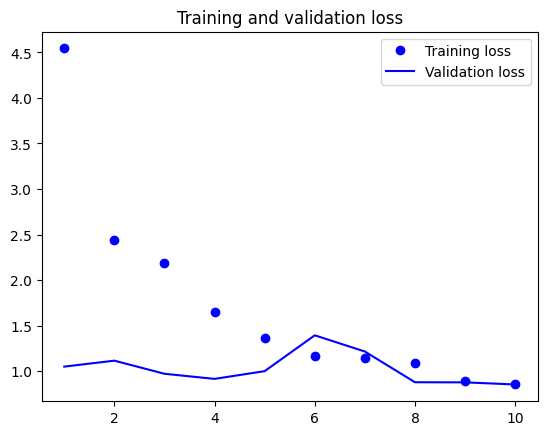

In [12]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [13]:
train_targets.shape

(6390, 200, 200, 1)

In [14]:
train_input_imgs.shape

(6390, 200, 200, 3)

In [15]:
train_input_imgs[0]

array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 253.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[252., 252., 252.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [254., 254., 254.],
        [253., 253., 253.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2